# Homework 2

### Deadline: Tuesday 20 May 2025 (by 19h00)

### Credits: 20 points


## Instructions:

- The homework is **individual**. Please include your name in the notebook.

- **Please send your compressed tar file with the following tree scheme:**

```
homework2.tar
    
    pdediffusion
    ├── metalconduction.ipynb
    ├── metalconduction.py     
    └── outputfolder
```

## Name: Alan Palma Travez

## 1. Thermodynamics and Heat Conduction (12 points)

Please include your solutions to this problem within a single python notebook file: **metalconduction.ipynb**

Use appropriate numerical algorithms to study how the temperature profile in a heated metal wire evolves in time, under different initial and boundary conditions. For this, you need to numerically solve the 1D heat equation:

$$\frac{\partial T}{\partial t}=\alpha\frac{\partial^2 T}{\partial x^2}$$

where $T=T(x, t)$ describes the temperature of the metal, $x$ is position, $t$ is time, and $\alpha$ is the thermal diffusivity of the metal. We will consider the following metals:

| Metal      | $\alpha$ ($\frac{mm^2}{s}$) |
|------------|--------------------------|
| Copper     | 111                      |
| Iron       | 23                       |
| Aluminum   | 97                       |
| Brass      | 34                       |
| Steel      | 18                       |
| Zinc       | 63                       |
| Lead       | 22                       |
| Titanium   | 9.8                      |

Assume that the metal wire has a length of $20\,\rm cm$, and choose the wire midpoint as the origin for the domain.

### Code design:

Organise your code using **python classes** and carry out the following tasks:

**(a)** Place the metals and diffusivities in a python dictionary.


In [256]:
# Dictionary with metal difussivity coefficients (mm^2/s)

alpha_dic = {
    "Cu": 111,
    "Fe": 23,
    "Al": 97,
    "brass": 34,
    "steel": 18,
    "Zn": 63,
    "Pb": 22,
    "Ti": 9.8 
}

**(bx2)** Create a simulation initialisation routine where e.g. the mesh, the initial conditions, and the boundary conditions are all set up.

Consider two types of **initial conditions**:

- **Smooth**, which sets the initial temperature profile in degrees Celsius to be:

$$T(x, 0)= 175 - 50\cos\left(\frac{\pi x}{5}\right) - x^2$$

where $x$ is in units of $\rm cm$. 

- **Noisy**, which adds some noise $f(x)$ with amplitude $\beta$ to the initial condition:

$$T(x, 0)= 175 - 50\cos\left(\frac{\pi x}{5}\right) - x^2 + \beta\,f(x)\,g(x)$$

Note that you need to find an appropriate apodisation function $g(x)$ so that the initial boundary conditions remain fixed at $25\,\rm C$. Similarly, a default amplitude for the noise function can be set to be less than a hundredth of the peak temperature value. 

Also, consider two types of **boundary conditions**:

- **Fixed**, which keep the temperatures at the edges of the metal wire fixed at a temperature of $25\,\rm C$. 
    
- **Varying**, which assume that the boundaries cannot be kept constant (because of e.g. a faulty cooling system). Instead they also evolve in time according to the following functions:

    $T(+10\,{\rm cm}, t) = 25 + 0.12\,t$

    $T(-10\,{\rm cm}, t) = 25 + 0.27\,t$

In [257]:
# Third party libraries
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import time 
import pandas as pd
import os
from joblib import Parallel, delayed, cpu_count

# Define the style
plt.style.use(['science', 'notebook', 'no-latex']) # Use a specific style for figures

The apodisation function is:

$$
g(x) = \sin^{2}\left(\pi \frac{x - x_{min}}{x_{max} - x_{min}}\right)
$$

in this way we find that:
- At $x = x_{min}$, $g(x)=0$
- At $x = x_{max}$, $g(x)=0$

In [258]:
def gx(x, x_min, x_max):
    """
    Apodisation function to smoothly suppress noise near the boundaries.
        Inputs:
            x (array): Spatial grid array.
            x_min (float): Minimum value of the spatial domain.
            x_max (float): Maximum value of the spatial domain.
        Output:
            apodization (ndarray): Values of the smoothing function at each x.
    """

    return np.sin(np.pi * (x - x_min) / (x_max - x_min))**2


def smooth_initial_condition(x):
    """
    Smooth temperature profile.
        Inputs:
            x (array): Spatial grid array.
        Outputs:
            T0 (array): Initial temperature profile at t = 0.
    """

    return 175 - 50 * np.cos(np.pi * x / 5) - x**2

def choose_ics(ic_type, x, beta):
    """
    Returns the initial condition (IC) profile, either smooth or with noise.
        Inputs:
            ic_type (str): Type of initial condition. Options: "Smooth" or "Noisy".
            x (array): Spatial grid array.
            beta (float): Amplitude of the added noise (or "Noisy").
        Outputs:
            ics (array): Array of initial temperatures.
    """

    if ic_type == "Smooth":
        ics = smooth_initial_condition(x)

    elif ic_type == "Noisy":
        fx = np.random.randn(len(x)) # Noise function
        ics = smooth_initial_condition(x) + beta * fx * gx(x, x[0], x[-1])

    else:
        raise ValueError('Unknown initial condition type. Use "Smooth" or "Noisy".')

    return ics

def choose_bcs(bc_type, t):
    """
    Returns boundary conditions for all times depending on the selected type.
        Inputs:
            bc_type (str): Type of boundary condition. Options: "Fixed" or "Varying".
            t (array): Temporal grid array.
        Outputs:
            bcs (array): Array containing left and right boundary temperature values.
    """

    if bc_type == "Fixed":
        bcs = [25., 25.]

    elif bc_type == "Varying":
        bc_i = lambda t: 25. + 0.12*t
        bc_f = lambda t: 25. + 0.27*t

        bcs = [bc_i(t), bc_f(t)]
    else:
        raise ValueError('Unknown initial condition type. Use "Fixed" or "Varying".')

    return bcs

def initialize(h, k, bc_type, ic_type, beta = 1.0):
    """
    Initializes the simulation arrays for solving the heat equation.
        Inputs:
            h (float): Spatial step size.
            k (float): Temporal step size.
            bc_type (str): Type of boundary condition ("Fixed" or "Varying").
            ic_type (str): Type of initial condition ("Smooth" or "Noisy").
            beta (float): Noise amplitude for "Noisy" IC. Default is 1.0.
        Outputs:
            T (array): 2D temperature array [space, time].
            x (array): Spatial grid.
            t (array): Temporal grid.
    """

    # Initialize the time and space arrays
    t = np.arange(0, 2000.+ k, k)
    x = np.arange(-10, 10, h)

    # Define ICs
    ics = choose_ics(ic_type, x, beta)

    # Define BCs
    bcs = choose_bcs(bc_type, t)

    # Create the solution array 
    T = np.zeros((len(x), len(t)))

    # Set the initial condition
    T[:, 0] = ics

    # Set the boundary conditions

    T[0, :] = bcs[0]
    T[-1, :] = bcs[1]

    return T, x, t

**(cx3)** Construct a Crank-Nicolson algorithm to simulate **the evolution of an initial temperature profile** and find the **time in seconds at which thermal equilibrium is reached** in an input metal wire (from the dictionary). **Hint:** You need to define some criteria to determine thermal equilibrium.

The citeria used for determinig thermal equilibrium is comparing the mean of the two final temperature profiles for consecutive times until reach a tolerance level. 

$$
mean(|T(x, j+1)-T(x, j)|) < tol.
$$

In this case tolarence is a parameter since depeding the BCs and ICs the value needs to be adjusted to find appropiate results.

In [259]:
def find_eq(T, tol, t_arr, metal):
    """
    Determine the time at which thermal equilibrium (steady state) is reached,
    based on a tolerance for the mean temperature change over time.
    Inputs:
        T (array): 2D temperature array [space, time].
        tol (float): Tolerance for change in mean temperature to consider equilibrium.
        t_arr (ndarray): Time array.
        metal (str): Name of the material for printing status message.

    Outputs:
        t0_indx (int or None): Index of the time step when equilibrium is reached. None if not reached.
        t0 (float or None): Actual time when equilibrium is reached. None if not reached.
    """

    # Termal equlibrium flag
    t_eq = False

    # Time lenght
    m = len(t_arr)

    # Iterate over time steps
    for j in range(0, m-1):
        
        # Obtauin the mean temperature change
        dT_mean = np.mean(np.abs(T[:, j] - T[:, j+1]))

        if dT_mean < tol:
            t0 = t_arr[j+1]
            t0_indx = j + 1 
            t_eq = True
            break
    if t_eq:
        print("Steady state for " + metal + f" wire reached at t = {t0:.2f} s")
        return t0_indx, t0
    else:   
        print("Steady state not reached")
        t0 = None
        t0_indx = None
        return t0_indx, t0

def crank_nicolson(T, h, k, t_arr, tol, metal):
    """
    Solve the heat equation using the Crank-Nicolson method.
        Inputs:
            T (array): 2D array [space, time] initialized with ICs and BCs.
            h (float): Spatial step size.
            k (float): Temporal step size.
            t_arr (array): Array of time points.
            tol (float): Tolerance for reaching thermal equilibrium.
            metal (str): Metal type used to determine thermal diffusivity.
        Outputs:
            t0_indx (int or None): Index of the time step when equilibrium is reached. None if not reached.
            t0 (float or None): Time when equilibrium is reached. None if not reached.
            T (array): Updated temperature array after solving the equation.
    """

    # Termal equilibrium flag
    t0 = None
    t0_indx = None

    # Select the metal 
    alpha = alpha_dic[metal]

    # Compute r factor
    alpha = alpha * 1e-2 # mm^2/s to cm^2/s
    r_factor = alpha * k / h**2

    # Dimentions
    n = T.shape[0] # Number of points in space
    m = T.shape[1] # Number of points in time

    # Create the D1 matrix

    D1_matrix_0 = np.diag([2 + 2*r_factor]*(n - 2), 0)
    D1_matrix_n = np.diag([-r_factor]*(n - 3), -1)
    D1_matrix_p = np.diag([-r_factor]*(n - 3), +1)

    D1_matrix   = D1_matrix_0 + D1_matrix_n + D1_matrix_p # Sum all

    # Create the D2 matrix
    D2_matrix_0 = np.diag([2 - 2*r_factor]*(n - 2), 0)
    D2_matrix_n = np.diag([r_factor]*(n - 3), -1)
    D2_matrix_p = np.diag([r_factor]*(n - 3), +1)

    D2_matrix   = D2_matrix_0 + D2_matrix_n + D2_matrix_p # Sum all

    # print(D1_matrix)
    # print(D2_matrix)

    # Solve the linear sytem of equations

    # Iterate over time steps
    for j in range(0, m-1):
        
        # Add initial conditions to initial b vector
        b = T[1:-1, j].copy()
        #print(b.shape)
        #print(b)

        # Evaluate RHS
        b = np.dot(D2_matrix, b)
        # b = D2_matrix@b (another option)
        #print(b)
        
        # Append missing values
        
        b[0]  = b[0]  + r_factor*(T[0, j+1] + T[0, j])
        b[-1] = b[-1] + r_factor*(T[-1, j+1] + T[-1, j])
        
        # Compute the solution vector:
        sln_b = np.linalg.solve(D1_matrix, b)
        
        # Update T matrix
        T[1:-1, j+1] = sln_b

    t0_indx, t0 = find_eq(T, tol, t_arr, metal)
  
    return t0_indx, t0, T

In [260]:
# Intialization 

h = 0.1  # Space spacng
k = 1. # Time spacing
bc_t = "Fixed" # Boundary conditions
ic_t = "Smooth" # Initial conditions

T, x_arr, t_arr = initialize(h, k, bc_t, ic_t)

In [261]:
# Define the tolerance level
tol = 0.01

# Execute the simulation
teq_indx, teq, T_sol = crank_nicolson(T, h, k, t_arr, tol, "Cu")

Steady state for Cu wire reached at t = 209.00 s


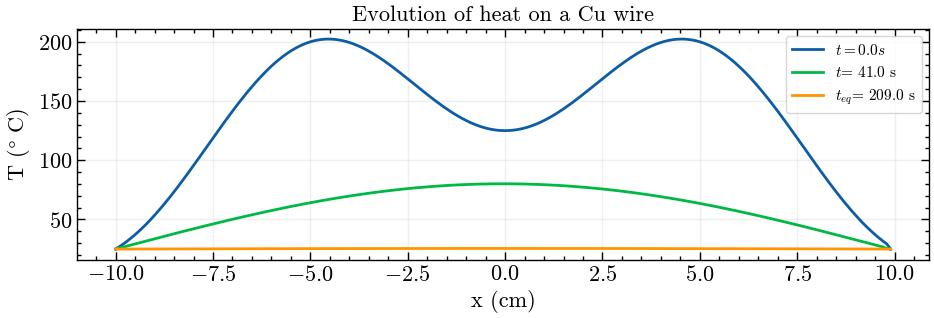

In [262]:
# Plotting
plt.figure(figsize=(11,3))

plt.plot(x_arr, T_sol[:, 0], label = r"$t = 0.0 s$")
plt.plot(x_arr, T_sol[:, teq_indx // 5], label = r"$t$"+ f"= {t_arr[teq_indx//5]} s")
plt.plot(x_arr, T_sol[:, teq_indx], label = r"$t_{eq}$" + f"= {t_arr[teq_indx]} s")

plt.title("Evolution of heat on a Cu wire")
plt.xlabel("x (cm)")
plt.ylabel(r"T ($\degree$ C)")

plt.grid(alpha = 0.2)
plt.legend(frameon = True, fontsize = 11)
plt.show()

### Smooth-Fixed Simulations:

**(d)** Pick **two metal wires** from the dictionary and run both simulations using your Crank-Nicolson algorithm. To compare the results, make a high-quality, 2-column figure showing the time evolution of the 1D temperature profile, $T=T(x, t)$, of each metal wire versus $x$ at a few selected times.

In [263]:
# Define parameters for the simulation

h = 0.1 # Space step
k = 1.0 # Time step
bc_t = "Fixed" # Fixed boundary conditions 
ic_t = "Smooth" # Smooth inital conditions
tol = 0.01

In [264]:
# Execute the simulations

# Iron
T_2, x_arr, t_arr = initialize(h, k, bc_t, ic_t)
teq_indx_Fe, teq_Fe, T_sol_Fe = crank_nicolson(T_2, h, k, t_arr, tol, "Fe")

# Aluminium
T_3, x_arr, t_arr = initialize(h, k, bc_t, ic_t)
teq_indx_Al, teq_Al, T_sol_Al = crank_nicolson(T_3, h, k, t_arr, tol, "Al")

Steady state for Fe wire reached at t = 722.00 s
Steady state for Al wire reached at t = 233.00 s


In [265]:
# Define the array for plotting

t_plt_arr = [0, 25, 50, 75, 100, 125, 150, 175, 200]

# Solutions 
T_sols = {"Fe": T_sol_Fe, "Al" : T_sol_Al}

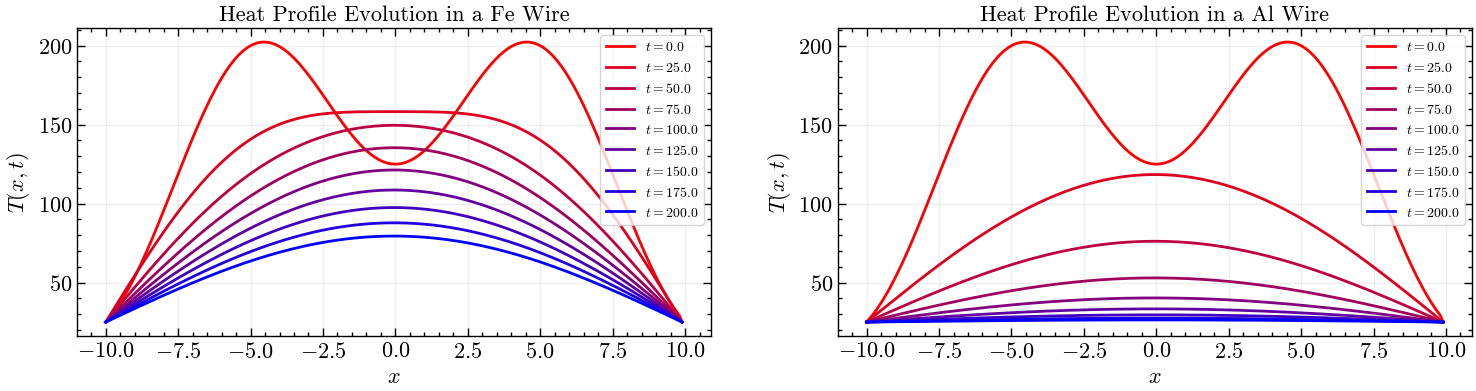

In [266]:
# Figure environment
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Plotting
R = np.linspace(1, 0, len(t_plt_arr))
G = 0
B = np.linspace(0, 1, len(t_plt_arr))

for i in range(len(ax)):

    ii = 0
    for j in t_plt_arr:
        T_plt = list(T_sols.values())[i]
        ax[i].plot(x_arr, T_plt[:,j], label = r"$t = $" + f"{t_arr[j]}", color = [R[ii], G, B[ii]])

        ii += 1

    ax[i].legend(frameon = True, fontsize = 10, loc = 1)
    ax[i].set_title(f"Heat Profile Evolution in a {list(T_sols.keys())[i]} Wire")
    ax[i].grid(alpha = 0.2)

    ax[i].set_xlabel(r"$x$")
    ax[i].set_ylabel(r"$T(x,t)$")

plt.show()

### Smooth-Fixed versus Noisy-Fixed Simulations:

**(e)** Study heat diffusion only in the Zinc wire considering **smooth versus noisy initial conditions** with noise of 3 different amplitudes. To compare the results, make a high-quality, 4-panel figure (with 2 columns and 2 rows) showing the time evolution of the 1D temperature profile, $T=T(x, t)$, of the Zinc metal wire versus $x$ at a few selected times, under different initial conditions (smooth vs. 3 noisy cases).

In [267]:
# Define an array for noise
beta_arr = np.linspace(1.0, 5.0, 3)

# Define intial parameters
h = 0.1 # Space step
k = 1.0 # Time step
tol = 0.01 # Tolerance

T_sols_Zn = {}

# Run simulation with smooth conditions
bc_t = "Fixed" # Fixed boundary conditions 
ic_t = "Smooth" # Smooth inital conditions
T_4, x_arr, t_arr = initialize(h, k, bc_t, ic_t)
teq_indx_Sm, teq_Sm, T_sol_Sm = crank_nicolson(T_4, h, k, t_arr, tol, "Zn")
T_sols_Zn[0] = T_sol_Sm

# Run the simulations with noise

for beta in beta_arr:

    bc_t = "Fixed" # Fixed boundary conditions 
    ic_t = "Noisy" # Noisy inital conditions
    
    T_5, x_arr, t_arr = initialize(h, k, bc_t, ic_t, beta = beta)
    print(f"Noise amplitude: {beta}")
    teq_indx_Noise, teq_Noise, T_sol_Noise = crank_nicolson(T_5, h, k, t_arr, tol, "Zn")
    T_sols_Zn[beta] = T_sol_Noise

Steady state for Zn wire reached at t = 328.00 s
Noise amplitude: 1.0
Steady state for Zn wire reached at t = 328.00 s
Noise amplitude: 3.0
Steady state for Zn wire reached at t = 333.00 s
Noise amplitude: 5.0
Steady state for Zn wire reached at t = 341.00 s


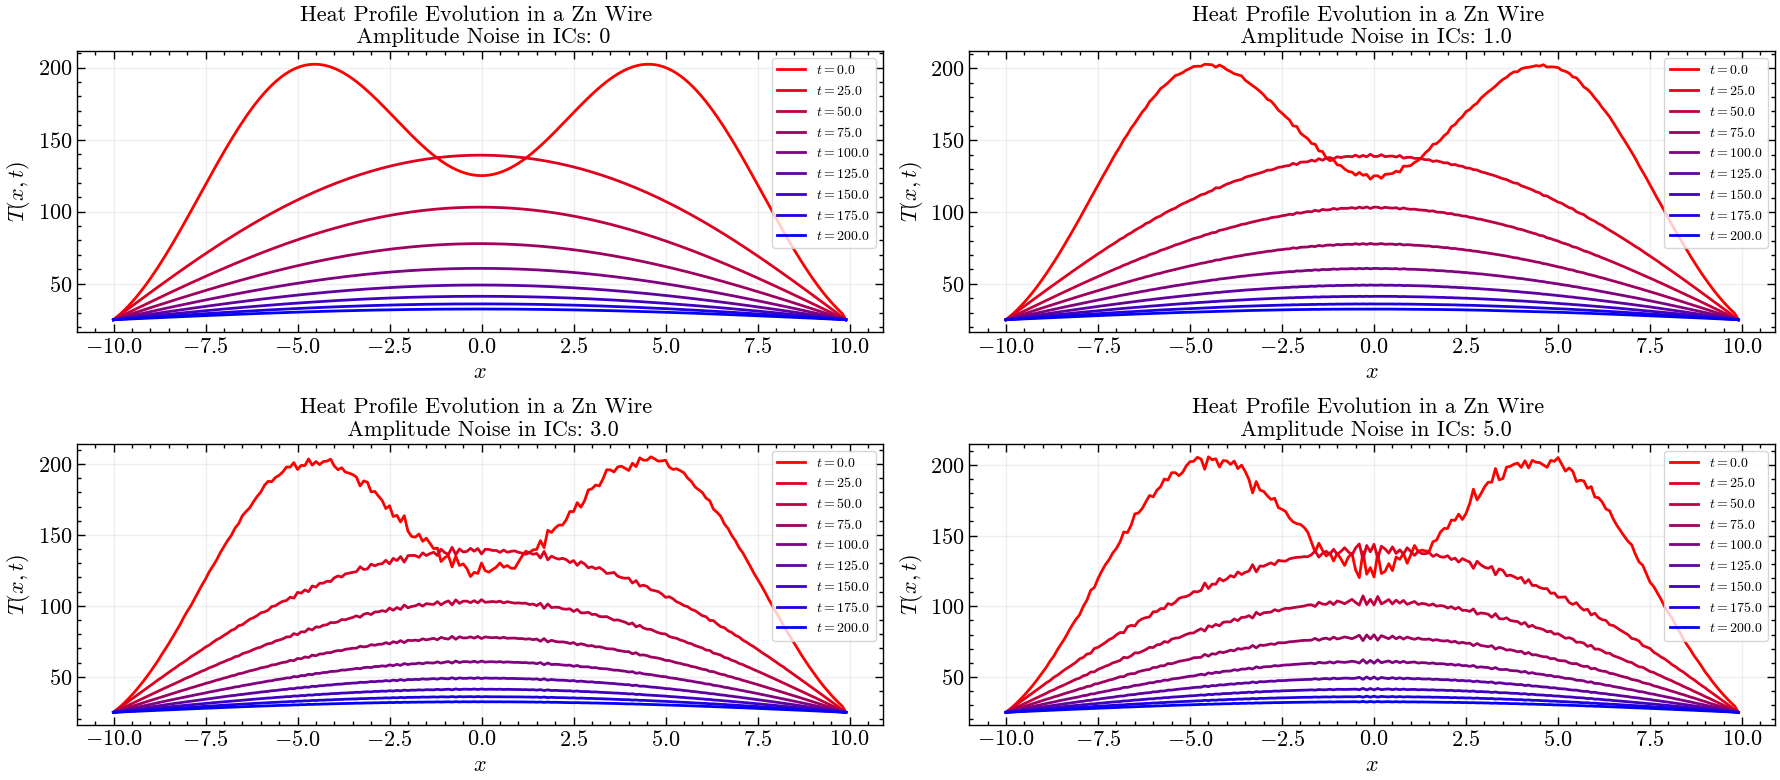

In [268]:
# Figure environment
fig, ax = plt.subplots(2, 2, figsize=(18,8))
axs = ax.flatten()

# Plotting
R = np.linspace(1, 0, len(t_plt_arr))
G = 0
B = np.linspace(0, 1, len(t_plt_arr))

for i in range(len(axs)):

    ii = 0
    for j in t_plt_arr:
        T_plt = list(T_sols_Zn.values())[i]
        axs[i].plot(x_arr, T_plt[:,j], label = r"$t = $" + f"{t_arr[j]}", color = [R[ii], G, B[ii]])
        axs[i].grid(alpha = 0.2)
        ii += 1

    axs[i].legend(frameon = True, fontsize = 10, loc = 1)
    axs[i].set_title(f"Heat Profile Evolution in a Zn Wire \n Amplitude Noise in ICs: {list(T_sols_Zn.keys())[i]}")
    

    axs[i].set_xlabel(r"$x$")
    axs[i].set_ylabel(r"$T(x,t)$")

plt.tight_layout()
plt.show()



### Smooth-Fixed versus Smooth-Varying Simulations:

**(f)** Study heat diffusion only in the Aluminum wire considering **fixed versus varying boundary conditions**. To compare the results, make a high-quality, 2-column figure showing the time evolution of the 1D temperature profile, $T=T(x, t)$, of the Aluminum metal wire versus $x$ at a few selected times, under different boundary conditions.

#### Tolerance = 0.01

In [269]:
# Define an array for noise
beta_arr = np.linspace(1.0, 5.0, 3)

# Define intial parameters
h = 0.1 # Space step
k = 1.0 # Time step
tol = 0.01 # Tolerance

T_sols_Al = {}

# Run simulation with fixed conditions
bc_t = "Fixed" # Fixed boundary conditions 
ic_t = "Smooth" # Smooth inital conditions
T_6, x_arr, t_arr = initialize(h, k, bc_t, ic_t)
teq_indx_Al_fix, teq_Al_fix, T_sol_Al_fix = crank_nicolson(T_6, h, k, t_arr, tol, "Al")
T_sols_Al[bc_t] = T_sol_Al_fix
 
# Run simulation with varying conditions
bc_t = "Varying" # Fixed boundary conditions 
ic_t = "Smooth" # Smooth inital conditions
T_7, x_arr, t_arr = initialize(h, k, bc_t, ic_t)
teq_indx_Al_var, teq_Al_var, T_sol_Al_var = crank_nicolson(T_7, h, k, t_arr, tol, "Al")
T_sols_Al[bc_t] = T_sol_Al_var


Steady state for Al wire reached at t = 233.00 s
Steady state not reached


#### Tolerance = 0.1

In [270]:
# Define an array for noise
beta_arr = np.linspace(1.0, 5.0, 3)

# Define intial parameters
h = 0.1 # Space step
k = 1.0 # Time step
tol = 0.1 # Tolerance

T_sols_Al = {}

# Run simulation with fixed conditions
bc_t = "Fixed" # Fixed boundary conditions 
ic_t = "Smooth" # Smooth inital conditions
T_6, x_arr, t_arr = initialize(h, k, bc_t, ic_t)
teq_indx_Al_fix, teq_Al_fix, T_sol_Al_fix = crank_nicolson(T_6, h, k, t_arr, tol, "Al")
T_sols_Al[bc_t] = T_sol_Al_fix
 
# Run simulation with varying conditions
bc_t = "Varying" # Fixed boundary conditions 
ic_t = "Smooth" # Smooth inital conditions
T_7, x_arr, t_arr = initialize(h, k, bc_t, ic_t)
teq_indx_Al_var, teq_Al_var, T_sol_Al_var = crank_nicolson(T_7, h, k, t_arr, tol, "Al")
T_sols_Al[bc_t] = T_sol_Al_var

Steady state for Al wire reached at t = 137.00 s
Steady state for Al wire reached at t = 107.00 s


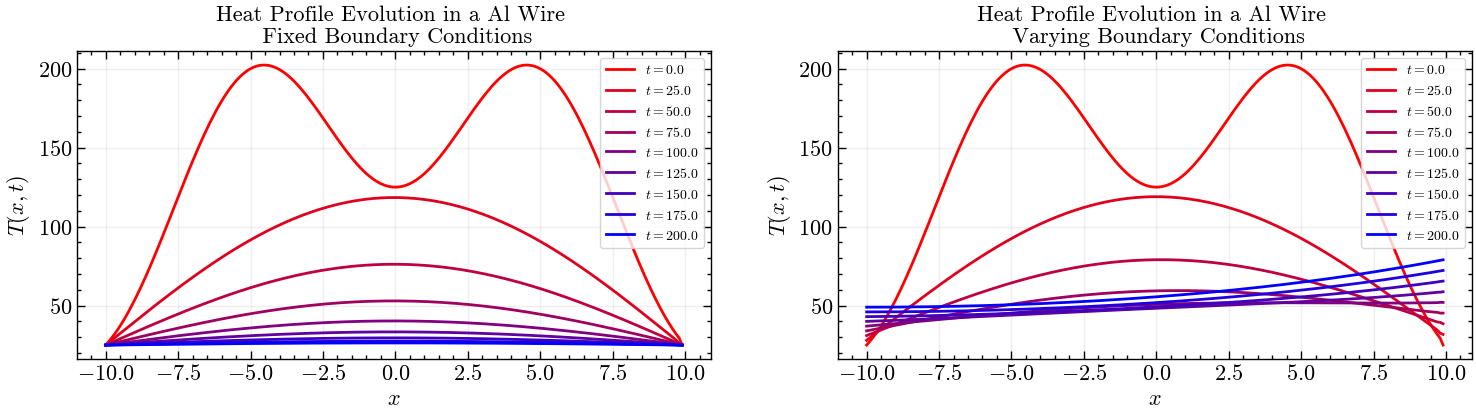

In [271]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Plotting
R = np.linspace(1, 0, len(t_plt_arr))
G = 0
B = np.linspace(0, 1, len(t_plt_arr))

for i in range(len(ax)):

    ii = 0
    for j in t_plt_arr:
        T_plt = list(T_sols_Al.values())[i]
        ax[i].plot(x_arr, T_plt[:,j], label = r"$t = $" + f"{t_arr[j]}", color = [R[ii], G, B[ii]])
        ax[i].grid(alpha = 0.2)
        
        ii += 1

    ax[i].legend(frameon = True, fontsize = 10, loc = 1)
    ax[i].set_title(f"Heat Profile Evolution in a Al Wire \n {list(T_sols_Al.keys())[i]} Boundary Conditions")

    ax[i].set_xlabel(r"$x$")
    ax[i].set_ylabel(r"$T(x,t)$")

plt.show()

### Analysis:

**(g)** Can we use explicit or FFT methods to solve this problem? Explain.

We could use explicit methods to solve this specific problem, but as we know, it is essential to take care of the stability constraints given by the r-factor ($\frac{k \alpha}{h²}$). On the other hand, it is not possible to use FFT-based methods or at least they are not suitable because these methods work with periodic boundary conditions, which is not the case here.

**(h)** Does the input noise amplitude change the time at which thermal equilibrium is reached or not? Why?

Yes, it changes the heat equilibrium time. This effect is produced by the small fluctuations introduced by the noise, which cause the system to take more time to reach thermal equilibrium. However, it is important to note that the noise should not affect the final state that the temperature profile reaches, but it will affect the time at which it is reached.



**(i)** What is the effect of a faulty cooling system on the temperature profile?

When the ends of the wire do not stay cold, this creates problems for the system to reach thermal equilibrium, given the tolerance that has been used throughout all the simulations ($tol = 0.01$). However, if we reduce the tolerance level to $0.1$, the system actually appears to reach an "equilibrium," but this is not enough to be considered a true steady state. In this sense, it becomes very difficult for the system to reach such a state, since the boundaries of the wire are increasing in temperature over time, and this heat should dissipate in each frame. If the rate at which the boundary conditions increase their temperature is larger than the material’s diffusivity capacity, it will be very difficult to reach a steady state.

## 2. Joblib Parallelisation (8 points)

Consider the same statement provided in problem 1. All code should be organised in **python classes**.


In [272]:
# Third party libraries
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import time 
import pandas as pd
import os
from joblib import Parallel, delayed, cpu_count

# Define the style
plt.style.use(['science', 'notebook', 'no-latex']) # Use a specific style for figures

In [273]:
class Initialisation():
    """
    Class to initialize the simulation parameters and arrays for solving the heat equation.
    """

    def __init__(self, h = 0.1, k = 1.0, bc_type = "Smooth", ic_type = "Fixed", beta = 1.0):
        """
        Constructor to initialize the simulation parameters.
            Inputs:
                h (float): Spatial step size.
                k (float): Temporal step size.
                bc_type (str): Type of boundary condition ("Fixed" or "Varying").
                ic_type (str): Type of initial condition ("Smooth" or "Noisy").
                beta (float): Noise amplitude for "Noisy" IC. Default is 1.0.
        """

        self.h = h
        self.k = k
        self.bc_type = bc_type
        self.ic_type = ic_type
        self.beta = beta

        # Initialize the simulation arrays
        self.T, self.x, self.t = self.initialize()

    @staticmethod
    def gx(x, x_min, x_max):
        """
        Apodisation function to smoothly suppress noise near the boundaries.
            Inputs:
                x (array): Spatial grid array.
                x_min (float): Minimum value of the spatial domain.
                x_max (float): Maximum value of the spatial domain.
            Output:
                apodization (ndarray): Values of the smoothing function at each x.
        """

        return np.sin(np.pi * (x - x_min) / (x_max - x_min))**2

    @staticmethod
    def smooth_initial_condition(x):
        """
        Smooth temperature profile.
            Inputs:
                x (array): Spatial grid array.
            Outputs:
                T0 (array): Initial temperature profile at t = 0.
        """

        return 175 - 50 * np.cos(np.pi * x / 5) - x**2

    def choose_ics(self, x):
        """
        Returns the initial condition (IC) profile, either smooth or with noise.
            Inputs:
                x (array): Spatial grid array.
            Outputs:
                ics (array): Array of initial temperatures.
        """

        if self.ic_type == "Smooth":
            ics = self.smooth_initial_condition(x)

        elif self.ic_type == "Noisy":
            fx = np.random.randn(len(x)) # Noise function
            ics = self.smooth_initial_condition(x) + self.beta * fx * self.gx(x, x[0], x[-1])

        else:
            raise ValueError('Unknown initial condition type. Use "Smooth" or "Noisy".')

        return ics

    def choose_bcs(self, t):
        """
        Returns boundary conditions for all times depending on the selected type.
            Inputs:
                t (array): Temporal grid array.
            Outputs:
                bcs (array): Array containing left and right boundary temperature values.
        """

        if self.bc_type == "Fixed":
            bcs = [25., 25.]

        elif self.bc_type == "Varying":
            bc_i = lambda t: 25. + 0.12*t
            bc_f = lambda t: 25. + 0.27*t

            bcs = [bc_i(t), bc_f(t)]
        else:
            raise ValueError('Unknown initial condition type. Use "Fixed" or "Varying".')

        return bcs

    def initialize(self):
        """
        Initializes the simulation arrays for solving the heat equation.
            Outputs:
                T (array): 2D temperature array [space, time].
                x (array): Spatial grid.
                t (array): Temporal grid.
        """

        # Initialize the time and space arrays
        t = np.arange(0, 1500.+ self.k, self.k)
        x = np.arange(-10, 10, self.h)

        # Define ICs
        ics = self.choose_ics(x)

        # Define BCs
        bcs = self.choose_bcs(t)

        # Create the solution array 
        T = np.zeros((len(x), len(t)))

        # Set the initial condition
        T[:, 0] = ics

        # Set the boundary conditions

        T[0, :] = bcs[0]
        T[-1, :] = bcs[1]

        return T, x, t

In [274]:
class CrankNicolson():
    """
    Class to solve the heat equation using the Crank-Nicolson method.
    """

    def __init__(self, obj, metal = "Cu", tol = 0.01):
        """
        Constructor to initialize the simulation parameters.
            Inputs:
                obj (Initialisation): Instance of the Initialisation class.
                metal (str): Type of metal used for the simulation.
                tol (float): Tolerance for reaching thermal equilibrium.
        """

        # Define the thermal diffusivity coefficients for different metals
        alpha_dic = {
            "Cu": 111,
            "Fe": 23,
            "Al": 97,
            "brass": 34,
            "steel": 18,
            "Zn": 63,
            "Pb": 22,
            "Ti": 9.8 
        }

        # Extract the data from initialisation object
        self.T = obj.T
        self.h = obj.h
        self.k = obj.k
        self.tol = tol
        self.metal = metal
        self.t_arr = obj.t

        # Select the metal 
        self.alpha = alpha_dic[metal]

        # Compute r factor
        self.alpha = self.alpha * 1e-2 # mm^2/s to cm^2/s
        self.r_factor = self.alpha * self.k / self.h**2

        # Dimentions
        self.n = obj.T.shape[0] # Number of points in space
        self.m = obj.T.shape[1] # Number of points in time

        # Create the D1 matrix

    def find_eq(self, T):
        """
        Determine the time at which thermal equilibrium (steady state) is reached,
        based on a tolerance for the mean temperature change over time.
            Inputs:
                T (array): 2D temperature array [space, time].
            Outputs:
                t0_indx (int or None): Index of the time step when equilibrium is reached. None if not reached.
                t0 (float or None): Actual time when equilibrium is reached. None if not reached.
        """

        # Termal equlibrium flag
        t_eq = False


        # Iterate over time steps
        for j in range(0, self.m-1):
            
            # Obtauin the mean temperature change
            dT_mean = np.mean(np.abs(T[:, j] - T[:, j+1]))

            if dT_mean < self.tol:
                t0 = self.t_arr[j+1]
                t0_indx = j + 1 
                t_eq = True
                break
        if t_eq:
            print("Steady state for " + self.metal + f" wire reached at t = {t0:.2f} s")
            return t0_indx, t0
        else:   
            print("Steady state not reached")
            t0 = None
            t0_indx = None
    
    def solver(self):
        """
        Solve the heat equation using the Crank-Nicolson method.
            Outputs:
                t0_indx (int or None): Index of the time step when equilibrium is reached. None if not reached.
                t0 (float or None): Time when equilibrium is reached. None if not reached.
                T (array): Updated temperature array after solving the equation.
        """

        # Termal equilibrium flag
        t0 = None
        t0_indx = None


        # Create the D1 matrix

        D1_matrix_0 = np.diag([2 + 2*self.r_factor]*(self.n - 2), 0)
        D1_matrix_n = np.diag([-self.r_factor]*(self.n - 3), -1)
        D1_matrix_p = np.diag([-self.r_factor]*(self.n - 3), +1)

        D1_matrix   = D1_matrix_0 + D1_matrix_n + D1_matrix_p # Sum all

        # Create the D2 matrix
        D2_matrix_0 = np.diag([2 - 2*self.r_factor]*(self.n - 2), 0)
        D2_matrix_n = np.diag([self.r_factor]*(self.n - 3), -1)
        D2_matrix_p = np.diag([self.r_factor]*(self.n - 3), +1)

        D2_matrix   = D2_matrix_0 + D2_matrix_n + D2_matrix_p # Sum all

        # Solve the linear sytem of equations

        # Iterate over time steps
        for j in range(0, self.m-1):
            
            # Add initial conditions to initial b vector
            b = self.T[1:-1, j].copy()
            #print(b.shape)
            #print(b)

            # Evaluate RHS
            b = np.dot(D2_matrix, b)
            # b = D2_matrix@b (another option)
            #print(b)
            
            # Append missing values
            
            b[0]  = b[0]  + self.r_factor*(self.T[0, j+1] + self.T[0, j])
            b[-1] = b[-1] + self.r_factor*(self.T[-1, j+1] + self.T[-1, j])
            
            # Compute the solution vector:
            sln_b = np.linalg.solve(D1_matrix, b)
            
            # Update T matrix
            self.T[1:-1, j+1] = sln_b

        t0_indx, t0 = self.find_eq(self.T)
    
        return t0_indx, t0, self.T

### Parallelisation with joblib:

**(a)** Imagine we wish to run several simulations in parallel for the metals included in the dictionary. Within the **metalconduction.ipynb** notebook, create a routine that uses ```joblib``` to parallelise the simulation executions in $n$ CPUs.

In [275]:
class RunJoblib():
    """
    Class to run the Crank-Nicolson solver in parallel using joblib.
    """
    def __init__(self, h = 0.1, k = 1.0, tol = 0.01 ):
        """
        Initialize the RunJoblib class with simulation parameters.
            Inputs:
                h (float): Spatial step size.
                k (float): Temporal step size.
                tol (float): Tolerance for thermal equilibrium detection.
        """

        self.h = h 
        self.k = k
        self.tol = tol

    def objective_func(self, element):
        """
        Run a single Crank-Nicolson simulation for a given material element.
            Inputs:
                element (str): Name of the material.
            Outputs:
                result (list):  element (str), 
                                equilibrium time t0 (float), 
                                temperature solution T_sln (array).
        """

        # Create an instance of the Initialisation class
        init_obj = Initialisation(h = self.h, k = self.k , ic_type = "Smooth", bc_type = "Fixed")

        # Create an instance of the CrankNicolson class
        cn_solver = CrankNicolson(init_obj, element, tol = self.tol)
        _, t0, T_sln = cn_solver.solver()

        return [element, t0, T_sln]
    
    def run_joblib(self, n_cpu, elements):
        """
        Function to run the Crank-Nicolson simulation in parallel using joblib.
            Inputs:
                n_cpu (int): Number of CPU cores to use.
                elements (list of str): List of material names to simulate.
            Outputs:
                exc_time (float): Execution time in seconds.
                results (list): List of results for each element -> [element (str), t0 (float), T_sln (ndarray)]
        """

        # Time stamp at the beginning of the execution
        start = time.time()

        # Call joblib
        results= Parallel(n_jobs = n_cpu)(delayed(self.objective_func)(element) for element in elements)

        # Time stamp at the end of the execution
        end = time.time()

        exc_time = end - start

        # Print execution
        if n_cpu == 1:
            print("Execution time in serial: ", exc_time)
        else:
            print("Execution time in paralell: ", exc_time)

        return exc_time, results


**(b)** Test your implementation by running $2$ simulations ($1$ for Iron and $1$ for Lead) first in serial and then in parallel (simultaneously). For the serial run, $n=1$ CPU core. For the parallel run, $n=2$ CPU cores. The time should go down. **Hint:** You need to add time stamps to quantify and return log files with the execution times. 

In [276]:
# Define the elements to be simulated
elements_list = ["Fe", "Pb"]

In [277]:
# Number of CPUs
n_cpu = 2
n_cpu_list = np.arange(1, n_cpu + 1, 1)

In [278]:
# Instantiate the RunJoblib class
run_joblib = RunJoblib(h = 0.1, k = 1.0, tol = 0.01)

# Empty array for storing the results
time_list = []

# Empty list to store results per core
results_parall_list = []

# For lopp for runnign the simulations
for n_cpu in n_cpu_list:

    # Print the number of CPUs
    print(f"Number of CPUs: {n_cpu}")
    
    # Run the simulation in parallel
    time_serial, results_parll = run_joblib.run_joblib(n_cpu, elements_list)

    # Store the execution time
    time_list.append(time_serial)

    # Store the results
    results_parall_list.append(results_parll)

Number of CPUs: 1
Steady state for Fe wire reached at t = 722.00 s
Steady state for Pb wire reached at t = 746.00 s
Execution time in serial:  2.2128031253814697
Number of CPUs: 2
Steady state for Fe wire reached at t = 722.00 s
Steady state for Pb wire reached at t = 746.00 s
Execution time in paralell:  2.020862579345703


In [279]:
# Parlelisation data: time vs. number of CPUs

# Create pandas object 
df = pd.DataFrame({"n": n_cpu_list,
                    "time": time_list})

# Create an output directory if it does not exist
name_dir = "outputfolfder"

# Check if the directory exists, if not create it
if os.path.isdir(name_dir):
    print(f"Directory '{name_dir}' already exists.")
else:
    print(f"Directory '{name_dir}' has been created.")
    os.mkdir(name_dir)

# Save the data
df.to_csv(name_dir + "/time_joblib.csv", index = False)
print("Data saved in: ", name_dir + "\time_joblib.csv")

Directory 'outputfolfder' already exists.
Data saved in:  outputfolfder	ime_joblib.csv



**(c)** Make a scaling plot showing (serial and parallel) execution times in the $Y$ axis versus the number of CPU cores ($n$) in the $X$ axis.

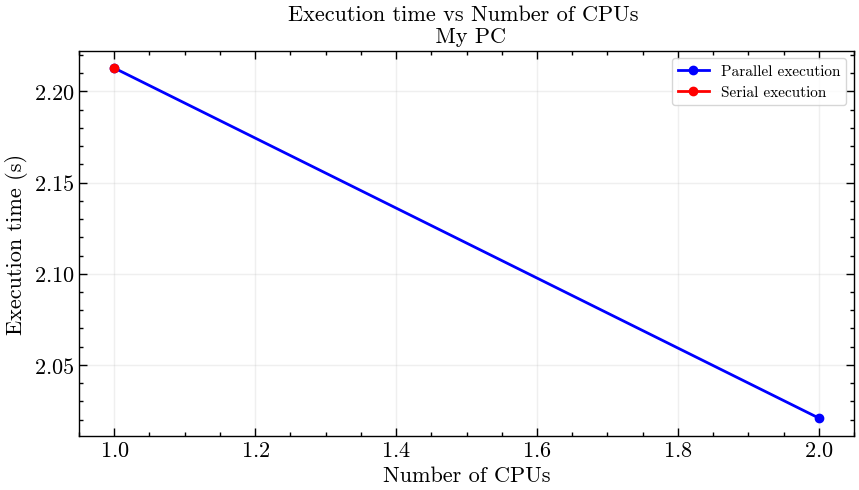

In [280]:
# Plotting the data
plt.figure(figsize=(10, 5))

plt.plot(n_cpu_list, time_list, marker = "o", color = "blue", label = "Parallel execution")
plt.plot(n_cpu_list[0], time_list[0], marker = "o", color = "red", label = "Serial execution")

plt.title("Execution time vs Number of CPUs \n My PC")
plt.xlabel("Number of CPUs")
plt.ylabel("Execution time (s)")

plt.grid(alpha = 0.2)
plt.legend(frameon = True, fontsize = 11)

plt.show()

### HPC execution:

**(d)** Convert your notebook code into a script called: **metalconduction.py**. Then, copy it to the CEDIA cluster (or the Imbabura cluster), reserve computing resources (e.g. $8$ CPU cores), then run your code in serial and parallel for all the $8$ metals at increasing $n$ (e.g. $1$, $2$, $4$, $8$ CPU cores). Export log files from each run, so that the thermal equilibrium times and simulation run times can be analysed later. Include the log files and all your SLURM job scripts in the **outputfolder.**


**(e)** Within the **metalconduction.ipynb** notebook, create a routine to open the log files produced by the serial run and all the different parallel runs on the HPC cluster.

In [281]:
def read_data(filename):
    """
    Read data from a CSV file and return it as a pandas DataFrame.
        Inputs:
            filename (str): Path to the CSV file.
        Outputs:
            df (DataFrame): Data read from the CSV file.
    """

    # Read the data
    df = pd.read_csv(filename, sep = ",", header = 0)

    # Extract the data
    time = df["time"].values
    n_cpu = df["n"].values

    return n_cpu, time

**(f)** Make a new scaling plot for the HPC cluster showing the executions times on the Y-axis and number of cores on the X-axis. Display also the **Amdahl's law**. 

In [282]:
def amdahl_law(t0, n_list):
    """
    Compute the theoretical speedup according to Amdahl's Law for ideal parallel execution.
        Inputs:
            t0 (float): Execution time using a single processor (serial execution).
            n_list (list): List of number of processors.
        Outputs:
            f (list): List of ideal speedup factors for each number of processors.
    """

    f = [t0/n for n in n_list]

    return f


In [283]:
# Read the data obtained from hpc
n_cpu_hpc, time_hpc = read_data("outputfolfder/time_joblib_hpc.csv")

In [284]:
# Compute Amdahl's law for our n cores

n_cpus = [1, 2, 4, 8]
f_al = amdahl_law(time_hpc[0], n_cpus)

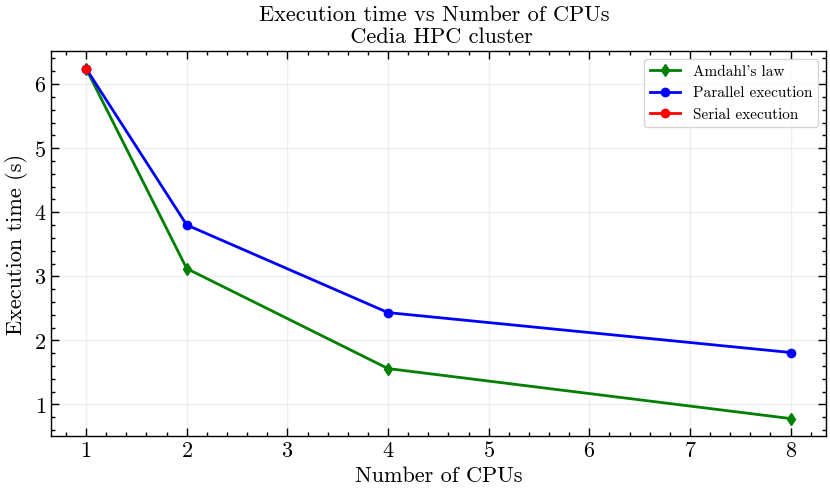

In [285]:
plt.figure(figsize=(10, 5))

plt.plot(n_cpus, f_al, marker = "d", color = "green", label = "Amdahl's law")
plt.plot(n_cpu_hpc, time_hpc, marker = "o", color = "blue", label = "Parallel execution")
plt.plot(n_cpu_hpc[0], time_hpc[0], marker = "o", color = "red", label = "Serial execution")

plt.title("Execution time vs Number of CPUs \n Cedia HPC cluster")
plt.xlabel("Number of CPUs")
plt.ylabel("Execution time (s)")

plt.grid(alpha = 0.2)
plt.legend(frameon = True, fontsize = 11)

plt.show()

### Analysis:

**(g)** Compare the Amdahl's law to your results and comment on the findings (e.g. does your parallelisation follow Amdahl's law? Why yes or no?)

Yes, the performance is close to the ideal predicted by Amdahl's Law, but it is not perfect. We must take into account the communication overhead between cores. An important observation is that, since we have eight different metals, the parallelization performs very well when using 8 cores by assigning one simulation to each core.

**(h)** Make a plot showing the thermal equilibrium times versus diffusivities. Do the different thermal equilibrium times for dstinct metals influence how ```joblib``` handles parallelisation?

In [286]:
def read_data_te(filename):
    """
    Read data from a CSV file and return it as a pandas DataFrame.
        Inputs:
            filename (str): Path to the CSV file.
        Outputs:
            df (DataFrame): Data read from the CSV file.
    """

    # Read the data
    df = pd.read_csv(filename, sep = ",", header = 0)

    # Extract the data
    t0 = df["t0"].values
    elements = df["elements"].values

    return elements, t0

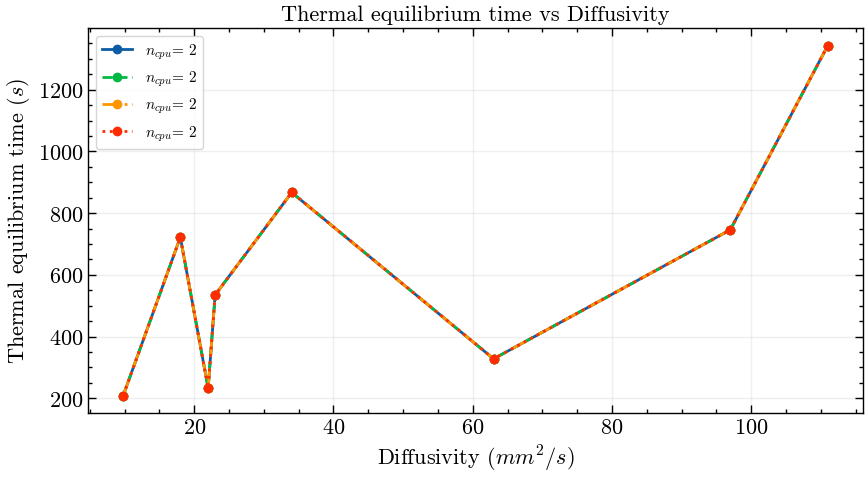

In [287]:
# Read and plot the data obtained
n_cpus = [1, 2, 4, 8]

# Linestyles 
line_styles = ["-", "--", "-.", ":"]


# Figure environment
plt.figure(figsize=(10, 5))

for i in range(len(n_cpus)):

    # Read the data
    elements, t0 = read_data_te(name_dir + f"/t0_joblib_n{n_cpus[i]}.csv")

    # Extract the diffusivity coefficients
    alpha = sorted([alpha_dic[element] for element in elements])

    # Plot for all cpu runs
    plt.plot(alpha, t0, marker = "o", linestyle = line_styles[i], label = r"$n_{cpu}$" + f"= {n_cpu}")

plt.title("Thermal equilibrium time vs Diffusivity")
plt.xlabel(r"Diffusivity ($mm^2/s$)")
plt.ylabel(r"Thermal equilibrium time ($s$)")

plt.grid(alpha = 0.2)
plt.legend(frameon = True, fontsize = 11)

plt.show()



Joblib parallelization only manages task distribution across cores; it does not affect the thermal equilibrium times. As shown in the plot, all the equilibrium times remain the same, indicating no correlation with the number of processes or how Joblib distributes them.